 A user has suggested ([GitHub issue](https://github.com/ebmdatalab/openprescribing/issues/2384)) that it would be useful to have a measure of injectable antibiotics to support ongoing audit and review in antimicrobial stewardship. [OPAT services](https://www.guysandstthomas.nhs.uk/resources/patient-information/infection/opat-service.pdf) ahould be prescribing any injectable antibiotics where they exist but it is possible in some areas the prescriptions are written by the GP. In this notebook we will explore patterns of injectable antibiotic prescribing.

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps

In [2]:
sql = '''
SELECT
    pct,
    CAST(month AS DATE) AS month,
    bnf_name,
    bnf_code,
    SUM(items) AS items,
    SUM(actual_cost) AS cost
FROM hscic.normalised_prescribing_standard presc
INNER JOIN hscic.practices pract ON presc.practice = pract.code
INNER JOIN
  hscic.ccgs AS ccg
ON
  presc.pct=ccg.code
WHERE
    ccg.org_type='CCG' AND
    pract.setting = 4 AND
    presc.bnf_code IN (
        SELECT DISTINCT(bnf_code)
        FROM ebmdatalab.measures.dmd_objs_with_form_route
        WHERE 
        (form_route LIKE '%intravenous%' OR
        form_route LIKE'%injection%' OR
        form_route LIKE'%subcutaneous')      
        AND bnf_code LIKE "050%")
GROUP BY pct, month, bnf_name, bnf_code
ORDER BY pct, month
'''

df_inj_abx = bq.cached_read(sql, csv_path='df_inj_abx.csv')
df_inj_abx['month'] = df_inj_abx['month'].astype('datetime64[ns]')
df_inj_abx.head()

,pct,month,bnf_name,bnf_code,items,cost
0,00C,2010-08-01,Colomycin_Inj 2 000 000u Vl (Dry),0501070I0BBACAE,1,284.65
1,00C,2010-08-01,Colistimeth Sod_Inj 2 000 000u Vl,0501070I0AAAEAE,1,28.49
2,00C,2010-08-01,Colomycin_Inj 1 000 000u Vl (Dry),0501070I0BBABAB,4,355.47
3,00C,2010-09-01,Colomycin_Inj 2 000 000u Vl (Dry),0501070I0BBACAE,3,483.94
4,00C,2010-09-01,Crystapen_Inj 600mg (1mega u) Vl (Dry),0501011J0BBABAB,1,1.21


(0, 5150.35)

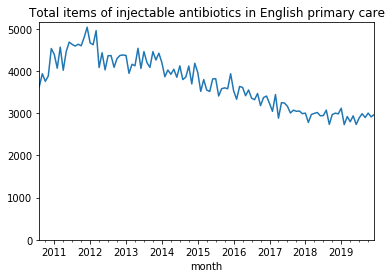

In [3]:
df_inj_abx.groupby("month")['items'].sum().plot(kind='line', title="Total items of injectable antibiotics in English primary care")
plt.ylim(0, )

In [4]:
df_inj_abx.nunique()

pct           191
month         113
bnf_name      215
bnf_code      193
items          67
cost        59923
dtype: int64

In [5]:
df_inj_abx["bnf_name"].unique()

array(['Colomycin_Inj 2 000 000u Vl (Dry)',
       'Colistimeth Sod_Inj 2 000 000u Vl',
       'Colomycin_Inj 1 000 000u Vl (Dry)',
       'Crystapen_Inj 600mg (1mega u) Vl (Dry)',
       'Colistimeth Sod_Inj 1 000 000u Vl',
       'Cidomycin_Inj 40mg/ml 2ml Vl', 'Ofloxacin_Inf 2mg/ml 100ml Vl',
       'Gentamicin Sulph_Inj 40mg/ml 2ml Amp',
       'Benzylpenicillin Sod_Inj 600mg Vl',
       'Gentamicin Sulph_Inj 40mg/ml 2ml Vl',
       'Fungizone_I/V Inf 50mg (Dry) Vl',
       'Genticin_Inj Soln 40mg/ml 2ml Amp',
       'Ceftriaxone Sod_Inj 250mg Vl', 'Amoxicillin Sod_Inj 500mg Vl',
       'Fluclox Sod_Inj 250mg Vl', 'Amikacin_Inj 250mg/ml 2ml Vl',
       'Ertapenem Sod_I/V Inf 1g Vl (Dry)', 'Vancomycin HCl_Inj 500mg Vl',
       'Daptomycin_I/V Inf 500mg Vl (Dry)',
       'Amoxil_Inj Pdr Vl 500mg (Dry)',
       'Gentamicin Sulf_Inj 40mg/ml 2ml Vl',
       'Gentamicin Sulf_Inj 40mg/ml 2ml Amp',
       'Colomycin_Inj 1,000,000u Vl (Dry)',
       'Colistimeth Sod_Inj 1,000,000u Vl',
    

In [6]:
##groupby bnf name  to see largest volume in terms of items
df_products = df_inj_abx.groupby(['bnf_code', 'bnf_name']).sum().reset_index().sort_values(by = 'items', ascending = False)
df_products.head(11)

,bnf_code,bnf_name,items,cost
118,0501070I0BBABAB,Colomycin_Inj 1 000 000u Vl (Dry),102770,9.758965e+06
120,0501070I0BBACAE,Colomycin_Inj 2 000 000u Vl (Dry),57573,9.484061e+06
119,0501070I0BBABAB,"Colomycin_Inj 1,000,000u Vl (Dry)",36837,3.674102e+06
113,0501070I0AAABAB,Colistimeth Sod_Inj 1 000 000u Vl,31737,3.282208e+06
82,0501040H0AAAAAA,Gentamicin Sulf_Inj 40mg/ml 2ml Amp,23733,8.438198e+05
121,0501070I0BBACAE,"Colomycin_Inj 2,000,000u Vl (Dry)",21466,3.684278e+06
115,0501070I0AAAEAE,Colistimeth Sod_Inj 2 000 000u Vl,19618,3.300304e+06
114,0501070I0AAABAB,"Colistimeth Sod_Inj 1,000,000u Vl",13031,1.327581e+06
116,0501070I0AAAEAE,"Colistimeth Sod_Inj 2,000,000u Vl",10706,1.844420e+06
125,0501070T0AAAAAA,Teicoplanin_Inj 400mg Vl + Dil,9846,6.376140e+05


There may be an rugument for excluding colomycin as although it is injecatble it will mostly be used as an inhaled therapy in treatement of infections in cystic fibrosis

## Maps and charts

In [7]:
sql2 = """
SELECT
  month,
  pct_id AS pct,
  SUM(total_list_size) AS list_size
FROM
  ebmdatalab.hscic.practice_statistics
GROUP BY
  month,
  pct
ORDER BY
  month,
  pct,
  list_size
"""
df_list = bq.cached_read(sql2, csv_path='listsize.csv')
df_list['month'] = df_list['month'].astype('datetime64[ns]')
df_list.head(5)

,month,pct,list_size
0,2015-01-01,NaN,0
1,2015-01-01,00C,106673
2,2015-01-01,00D,288824
3,2015-01-01,00F,207011
4,2015-01-01,00G,163290


In [8]:
ccg_total_abx = df_inj_abx.groupby(["month", "pct"])["items"].sum().reset_index()
ccg_total_abx.head(5)

,month,pct,items
0,2010-08-01,00C,6
1,2010-08-01,00D,21
2,2010-08-01,00J,29
3,2010-08-01,00K,14
4,2010-08-01,00L,32


In [9]:
df_abx_1000 = pd.merge(ccg_total_abx, df_list, on=['month', 'pct'])
df_abx_1000['inj_abx_items_per_1000'] = 1000* (df_abx_1000['items']/df_abx_1000['list_size'])
df_abx_1000.head(5)

,month,pct,items,list_size,inj_abx_items_per_1000
0,2015-01-01,00C,5,106673,0.046872
1,2015-01-01,00D,26,288824,0.090020
2,2015-01-01,00J,14,252951,0.055347
3,2015-01-01,00K,17,293006,0.058019
4,2015-01-01,00L,32,322094,0.099350


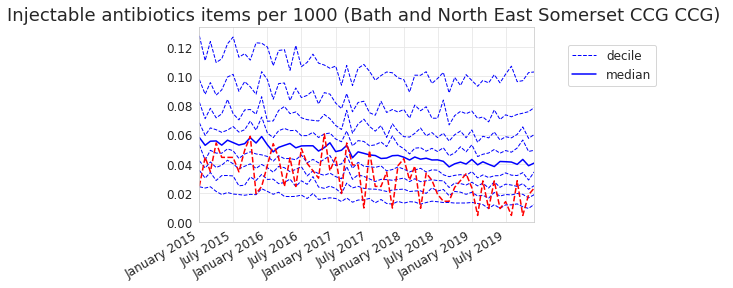

In [10]:
#create sample deciles & prototype measure
charts.deciles_chart(
        df_abx_1000,
        period_column='month',
        column='inj_abx_items_per_1000',
        title="Injectable antibiotics items per 1000 (Bath and North East Somerset CCG CCG) ",
        show_outer_percentiles=False)

#add in example CCG (Islington)
df_subject = df_abx_1000.loc[df_abx_1000['pct'] == '11E']
plt.plot(df_subject['month'], df_subject['inj_abx_items_per_1000'], 'r--')

plt.show()

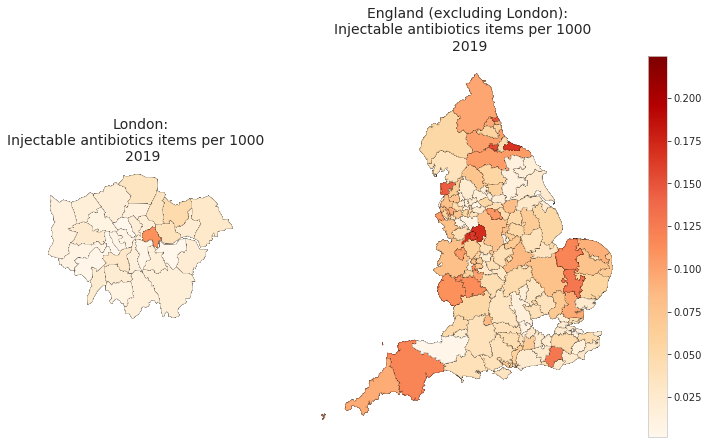

In [11]:
#create choropeth map of cost per 1000 patients
plt.figure(figsize=(12, 7))
latest_df_abx_1000 = df_abx_1000.loc[(df_abx_1000['month'] >= '2019-01-01') & (df_abx_1000['month'] <= '2019-12-01')]
plt = maps.ccg_map(latest_df_abx_1000, title="Injectable antibiotics items per 1000  \n  2019 ", column='inj_abx_items_per_1000', separate_london=True)
plt.show()